In [1]:
import numpy as np
from scipy.fft import fft2, ifft2, ifftshift, fftshift
from scipy.stats import norm
import matplotlib.pyplot as plt
import h5py
import numpy as np
import oculus.research.orcoptics.storage_async as storage_asyncibikuvieuekgktgigtbefhjkuhtjnlln
from matplotlib import pyplot as plt
import os

def circ(x,y):
    return np.where(np.sqrt(x**2+y**2)<=0.5, 1, 0)
def wvprop(amp, phi, distance, delta, wv):
    us = amp * np.exp(1j * phi)
    as_ = fftshift(fft2(ifftshift(us)))
    sy, sx = amp.shape
    fx = np.linspace(-1, 1, sx) / (2 * delta)
    fy = np.linspace(-1, 1, sy) / (2 * delta)
    fx, fy = np.meshgrid(fx, fy)
    r2 = fx**2 + fy**2
    asprop = as_ * np.exp(1j * 2 * np.pi / wv * distance * np.sqrt(1 - wv**2 * r2))
    us2 = ifftshift(ifft2(fftshift(asprop)))
    return us2
def binning(A, bs):
    s = A.shape
    B = np.reshape(A.flatten(), bs[0], s[0] // bs[0], [])
    B = np.reshape(np.transpose(B, [0, 2, 1]), bs[0], bs[1], [])
    B = np.sum(B, axis=(0, 1))
    B = np.reshape(B, s[:2])
    return B
def getNsr(img):
    nsr = np.std(img, keepdims=True) / np.mean(img, keepdims=True)
    return nsr
def generate_2d_gaussian(sigma, center2, size2):
    # Define the two-dimensional grid
    sizex, sizey = size2
    centerx, centery = center2
    x, y = np.meshgrid(np.linspace(-(sizey-1)/2-centery,(sizey-1)/2-centery,sizey), np.linspace(-(sizex-1)/2-centerx,(sizex-1)/2-centerx,sizex))
    # Calculate the distances from the center of the grid
    d = np.sqrt(x*x+y*y)
    # Define the standard deviation and calculate the 2D Gaussian matrix
    g = np.exp(-( (d)**2 / (  2*sigma**2 ) ) )
    g = g / np.sum(g)
    return g


def gaussmf(x, params):
    sigma, mean = params
    return norm.pdf(x, loc=mean, scale=sigma)

ModuleNotFoundError: No module named 'h5py'

In [2]:
pip install h5py

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 12.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Main code
wv_sim_group = {"r":0.638,"g":0.520,"b":0.450}
wv_sim_group = {"g":0.520}
wv_sim_num_group = {"r":80,"g":80,"b":80}
linewidth_group = {"r":0.002,"g":0.002,"b":0.002}

# pitch x, x is the ridge direction.
pitch_x = 80
# pitch y, the distance between two neighboring ridges.
pitch_y = 20
# distance between LCoS and pic, assuming air.
distance = 800
#emitter_size: sigma of the Gaussian-shape emitter in um.
emitter_size = 0.707
# index of the pic WG.
n = 1.5
# simulation resolution in um
delta = 1
# the number of emitters along x 
rep_num_x = 12
# the nukber of emitters along y
rep_num_y = 48
# number of ridges driven at different frequencies.
peroid = 6
# the amplitude of the random displacement along x.
randx = 5
# padding
padding = 0
# Lx, Ly are the matrix size of the simulation area.
Lx = pitch_x // delta
Ly = pitch_y // delta

# amp is the amplitude map at the emitter plane.
amp = np.zeros((Ly * rep_num_y, Lx * rep_num_x))
# creating x random displacement
rand_x_list = np.random.rand(rep_num_y, rep_num_x) * randx
# assign each emitter to the amp.
for i in range(rep_num_y):
    for j in range(rep_num_x):
        amp[Ly * i : Ly * (i + 1), Lx * j : Lx * (j + 1)] = generate_2d_gaussian(emitter_size / delta, [0, rand_x_list[i, j] / delta], [Ly, Lx])
# plot amplitude map of the emitter plane
plt.imshow(amp, cmap='gray')
plt.axis('off')
plt.show()


# assigning phase distribution;  phi_add_x_base: 
X, Y = np.meshgrid(np.arange(1, rep_num_x + 1) * pitch_x, np.arange(1, rep_num_y + 1) * pitch_y)
opd_list = (X + Y) * n
opd_list += n * rand_x_list
# assigning additonal phase from active phase modulation. phi_add_x_list stores the list of phase multiplier that is going to use in the simulation.
# phi_add_x_base is the base of the active phase for each frame. Here, assuming different rows are oscilating at 0, 1f, 2f, 3f, ... towards (peroid-1)f and repeat.
phi_add_x_list = np.linspace(2*np.pi/peroid,2*np.pi,peroid)
phi_add_x_base = np.kron(np.ones(rep_num_y // peroid), np.arange(peroid))
phi_add_x_base = np.kron(np.ones(rep_num_x),np.transpose([phi_add_x_base]))


#print(phi_add_x_base)
#print(opd_list)

In [26]:
us_group = {}
for cc, c in enumerate(wv_sim_group):
    wv = wv_sim_group[c]
    wv_sim_num = wv_sim_num_group[c]
    linewidth = linewidth_group[c]

    # initializing the field distribution.
    us_list = np.zeros((len(phi_add_x_list),wv_sim_num,Ly * rep_num_y + 2 * padding, Lx * rep_num_x + 2 * padding),dtype=np.complex_)
    # getting the wavelength list and weight
    wv_list = np.linspace(wv -  linewidth, wv + linewidth, wv_sim_num)
    wv_coef = gaussmf(wv_list, [linewidth / 2, wv])
    wv_coef = wv_coef / np.sum(wv_coef)
    # initializing the intensity distribution at LCoS
    imphi_sum = np.zeros((Ly * rep_num_y + 2 * padding, Lx * rep_num_x + 2 * padding))

    # sum for situation at different addtional phases.
    for j in range(len(phi_add_x_list)):
        imwv_list = np.zeros((len(wv_list), Ly * rep_num_y + 2 * padding, Lx * rep_num_x + 2 * padding))
        phi_add_x = phi_add_x_list[j] * phi_add_x_base
        # sum for situation at different wavelengths
        for i in range(len(wv_list)):
            lambda_ = wv_list[i]
            phi = 2 * np.pi / lambda_ * opd_list + phi_add_x
            # getting the phase map
            phi = np.kron(phi, np.ones((Ly, Lx)))
            # padding
            amp_pad = np.pad(amp, pad_width=padding)
            phi_pad = np.pad(phi, pad_width=padding)
            # angular spectrum algorithm
            us = wvprop(amp_pad, phi_pad, distance, delta, lambda_)
            # storing the results
            imwv_list[i, :, :] = np.abs(us) ** 2
            us_list[j ,i ,:, :] = us * np.sqrt(wv_coef[i])
        imwv_sum = np.sum(wv_coef.reshape(len(wv_coef), 1, 1) * imwv_list, axis=0)
        imphi_sum += imwv_sum
    us_list = us_list.reshape((len(phi_add_x_list)*wv_sim_num,Ly * rep_num_y + 2 * padding, Lx * rep_num_x + 2 * padding))
    size = len(us_list[0])
    # cutting the edge.
    us_list = us_list[:,size//3:size//3*2,size//3:size//3*2]
    us_group[c] = us_list

array([[0.06541619]])

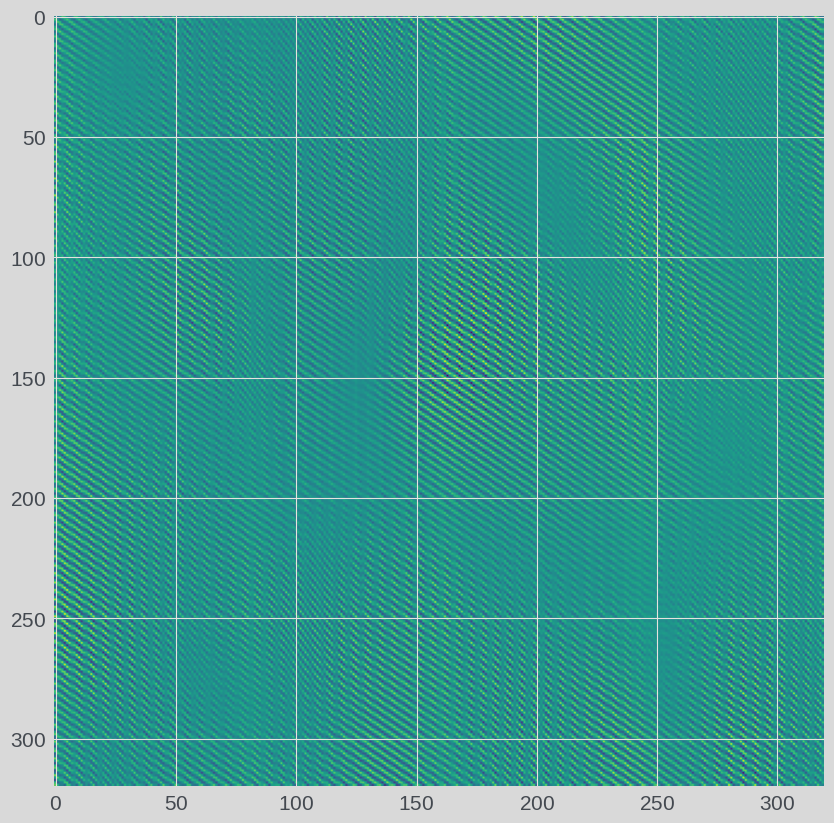

In [27]:
implot = imphi_sum[size//3:size//3*2,size//3:size//3*2]
plt.imshow(implot)
getNsr(implot)

In [ ]:
# upload to manifold

# Parameters (dims in um)
wavelengths = {
    "r": [0.638],
    "g": [0.520],
    "b": [0.450],
}

sampling_res = delta
sampling_img_size = len(us_group['g'][0])
sampling_npix = 2 * np.floor(sampling_img_size / sampling_res / 2)

x = sampling_npix * np.linspace(
    -sampling_res / 2, sampling_res / 2, sampling_npix.astype(int)
)
y = sampling_npix * np.linspace(
    -sampling_res / 2, sampling_res / 2, sampling_npix.astype(int)
)
xg, yg = np.meshgrid(x, y)

## Form h5 file with the relevant data
id = "X20um_Y80um_Gaussian1nm_period{}".format(peroid)  # ID for the simulation
file_name = "speckle_field_data_{}.h5".format(id)
path = "tree/epic/speckle/dynamic/activeLC/1nmGaussian/{}".format(file_name)

with h5py.File(file_name, "w") as h5:
    h5["sampling_res"] = sampling_res
    h5["sampling_npix"] = sampling_npix
    h5["sampling_img_size"] = sampling_img_size
    h5["x"] = x
    h5["y"] = y

    fields = h5.create_group("fields")
    for c, color in enumerate(wavelengths):
        color_set = h5.create_group(str(color))
        for w, wavelength in enumerate(wavelengths[color]):
            wavelength_set = h5.create_group(str(wavelength))
            us_list = us_group[color]
            for idx in range(len(us_list)):
                field = us_list[idx, :, :]
                wavelength_set[str(idx)] = field
            color_set[str(wavelength)] = wavelength_set
        fields[str(color)] = color_set
## Save file to Manifold (folder structure created automatically if not existing)
storage_async.manifold_upload_file(path=path, localfile=file_name, overwrite=True)